In [1]:
import matplotlib.pyplot as plt  
import pandas as pd  
import numpy as np 
import seaborn as sns
import os
from hsbmpy import get_file, define_labels, get_cluster_given_l
from sklearn.metrics import homogeneity_completeness_v_measure
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
level = 2
#setup = 'oversigma_10tissue'
#label = 'disease_type'
label='primary_site'
#label = 'uniq'
L = 4
#labels = ['primary_site', 'disease_type']
#labels = ['primary_site', 'secondary_site']
#directory = "results/hSBM/%s"%setup
#directory="gtex/hsbm/%s"%setup
directory="/Volumes/GoogleDrive/My Drive/tesi_magistrale/tesi/gtex/hsbm/oversigma_10tissue"
os.chdir(directory)

In [ ]:
df = pd.read_csv("mainTable.csv", index_col=[0], header=[0])
df.head()

In [ ]:
with open("clustersizes.txt",'r') as f:
    xl = np.array(f.read().split(sep='\n'))[:-1].astype(int)

In [ ]:
df.T.values.shape

In [ ]:
fig=plt.figure()
dend = shc.dendrogram(shc.linkage(df.T.values, method='ward'), leaf_rotation=90., leaf_font_size=8.,)
plt.xlabel("samples", fontsize=16)
plt.show()
fig.savefig("hierarchical_dendogram.pdf")

In [ ]:
df_files = pd.read_csv("files.dat", index_col=[0])
df_files.head()

In [ ]:
scores = {}
scores['hierarchical']={
    'h':[],
    'c':[],
    'V':[]
}
for x in xl:
    print("testing with %d clusters"%x)
    cluster = AgglomerativeClustering(n_clusters=x, affinity='euclidean', linkage='ward')  
    out = cluster.fit_predict(df.T.values)
    true_out = []
    for sample in df.columns.values:
        try:
            true_out.append(get_file(sample, df_files)['primary_site'])
        except:
            true_out.append('')
    score = (homogeneity_completeness_v_measure(true_out, out))
    scores['hierarchical']['h'].append(score[0])
    scores['hierarchical']['c'].append(score[1])
    scores['hierarchical']['V'].append(score[2])
    
pd.DataFrame(data=scores['hierarchical']).to_csv("hierarchical.scores", header=True, index=False)

## LDA

In [ ]:
with open("topicsizes.txt",'r') as f:
    tl = np.array(f.read().split(sep='\n'))[:-1].astype(int)

In [ ]:
scores['lda']={
    'h':[],
    'c':[],
    'V':[]
}
totalobjcets = len(df.columns)
for l,x in enumerate(xl[::-1]):
    #lda
    print("lda")
    ntopic = tl[l]
    lda = LatentDirichletAllocation(n_components=ntopic, random_state=42, n_jobs=2)
    topics = lda.fit_transform(df.T.values)
    
    #save topic distr
    print("saving topic-distr")
    df_topic_distr = pd.DataFrame(data=topics, columns=["Topic %d"%(t+1) for t in np.arange(tl[l])])
    df_topic_distr.insert(0,'i_doc',np.arange(len(df.columns)))
    df_topic_distr.insert(1,'doc',df.columns)
    df_topic_distr.to_csv("lda/lda_level_%d_topic-dist.csv"%l, index=False, header=True)
    
    #save clusters
    print("saving clusters")
    df_clusters = pd.DataFrame(index=np.arange(totalobjcets))
    cluster = AgglomerativeClustering(n_clusters=x, affinity='euclidean', linkage='ward')  
    out = cluster.fit_predict(topics)
    
    for c in np.arange(out.max()+1)[::-1]:
        c_objects = df.columns[np.argwhere(out==c)].values.T[0]
        df_clusters.insert(0,"Cluster %d"%(c+1),np.concatenate((c_objects,[np.nan for _ in np.arange(totalobjcets-len(c_objects))])))
    df_clusters.dropna(axis=0,how='all', inplace=True)
    df_clusters.to_csv("lda/lda_level_%d_clusters.csv"%(l), index=False, header=True)
    
    #metrics
    print("saving metrics")
    true_out = []
    for sample in df.columns.values:
        try:
            true_out.append(get_file(sample, df_files)['primary_site'])
        except:
            true_out.append('')
    score = (homogeneity_completeness_v_measure(true_out, out))
    scores['lda']['h'].append(score[0])
    scores['lda']['c'].append(score[1])
    scores['lda']['V'].append(score[2])
    break
pd.DataFrame(data=scores['lda']).to_csv("%s/lda.scores"%directory, header=True, index=False)

In [58]:
import tensorflow as tf
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
#tf.enable_eager_execution()

In [39]:
data = tf.constant([[1,2,3],[1,2,4],[1,3,3],[1,3,6],[3,4,8]], dtype=tf.float64)

In [40]:
def distance(data):
    return tf.map_fn(lambda A: tf.map_fn(lambda B: tf.norm(A-B), data), data)

In [4]:
def linkage(A,B):
    tf.squared_difference(A,B)

In [41]:
distances = distance(data)
n = distances.shape[0]
Z = []
nddistances = tf.reshape(tf.boolean_mask(distances,tf.logical_not(tf.equal(distances,tf.zeros_like(distances)))),(data.shape[0],data.shape[0]-1))
actual_minimums = tf.where(tf.equal(tf.reduce_min(nddistances),distances))

In [32]:
for i in range(n):
    Z.append([actual_minimums[0][0], actual_minimums[0][1],,2+i])
    newd=tf.norm(tf.squared_difference(tf.slice(data,[actual_minimums[0][0],0],[1,-1]),tf.slice(data,[actual_minimums[0][1],0],[1,-1])))

In [47]:
with tf.Session() as sess:
    ret = sess.run(actual_minimums)

In [48]:
ret

array([[0, 1],
       [0, 2],
       [1, 0],
       [2, 0]])

In [46]:
ret

array([[0.        , 1.        , 1.        , 3.16227766, 5.74456265],
       [1.        , 0.        , 1.41421356, 2.23606798, 4.89897949],
       [1.        , 1.41421356, 0.        , 3.        , 5.47722558],
       [3.16227766, 2.23606798, 3.        , 0.        , 3.        ],
       [5.74456265, 4.89897949, 5.47722558, 3.        , 0.        ]])

In [16]:
with tf.Session() as sess:
    print(sess.run(tf.argmin(ret, axis=1)))

[0 0 2 2 3]


{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [25.0, 25.0, 35.0, 35.0],
  [10.0, 10.0, 30.0, 30.0]],
 'dcoord': [[0.0, 1.0, 1.0, 0.0], [0.0, 1.0, 1.0, 0.0], [1.0, 2.0, 2.0, 1.0]],
 'ivl': ['0', '1', '2', '3'],
 'leaves': [0, 1, 2, 3],
 'color_list': ['g', 'r', 'b']}

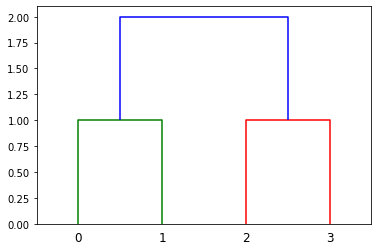

In [79]:
Z=[[0.,1.,1.,2.],[2.,3.,1.,2.],[4.,5.,2.,4.]]
dendrogram(Z)

In [27]:
Z=linkage([[1,2,3],[1,2,4],[1,2,6],[1,3,6],[3,4,8]])
Z

array([[0., 1., 1., 2.],
       [2., 3., 1., 2.],
       [5., 6., 2., 4.],
       [4., 7., 3., 5.]])

{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [35.0, 35.0, 45.0, 45.0],
  [20.0, 20.0, 40.0, 40.0],
  [5.0, 5.0, 30.0, 30.0]],
 'dcoord': [[0.0, 1.0, 1.0, 0.0],
  [0.0, 1.0, 1.0, 0.0],
  [1.0, 2.0, 2.0, 1.0],
  [0.0, 3.0, 3.0, 2.0]],
 'ivl': ['4', '0', '1', '2', '3'],
 'leaves': [4, 0, 1, 2, 3],
 'color_list': ['g', 'g', 'g', 'b']}

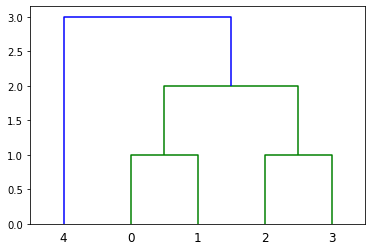

In [31]:
fig=plt.figure()
dendrogram(Z)

In [38]:
a=[]
a.append([1,2,3])
a.append([1,2])
a

[[1, 2, 3], [1, 2]]

In [49]:
from sklearn.cluster import AgglomerativeClustering

In [55]:
model = AgglomerativeClustering()
Z = model.fit_predict([[1,2,3],[1,2,4],[1,3,3],[1,3,6],[3,4,8]])

In [59]:
linkage([[1,2,3],[1,2,4],[1,3,3],[1,3,6],[3,4,8]])

array([[0.        , 1.        , 1.        , 2.        ],
       [2.        , 5.        , 1.        , 3.        ],
       [3.        , 6.        , 2.23606798, 4.        ],
       [4.        , 7.        , 3.        , 5.        ]])